# ML Experiments

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

In [2]:
# NOTE: This library isn't yet available publicly!
from nd_learn.api import *
from nd_learn.api.sklearn import SKLEst, SKLOp

import lightgbm as lgb

In [3]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [4]:
from m5.metrics import get_weights, get_rmsse, get_wrmsse, wrmsse_per_level, wrmsse_total

## Prepare Data

### Load

In [5]:
ds_all = load_ds()

In [6]:
ds = ds_all.where(ds_all['historic'], drop=True).drop(["historic", "future"])
# Fix dtype changes due to "where" mask
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Fixes and checks

Fill the price for when we don't know it:

In [7]:
ds['price'] = ds['price'].ffill(dim="date").bfill(dim="date")

Check that all values are nonnegative:

In [8]:
(ds<0).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

Check that we don't have any nulls in our data:

In [9]:
ds.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

### Create Features

We will calculate features now, to avoid having to create a pipeline.
(It's not available in nd_learn yet, and I don't have enough time to code it)

In [10]:
# raw_ds = ds.copy()

We can't use target lags directly, because we must do a prediction many steps ahead!

Categorical features (as integers, because LightGBM can encode them natively)

In [11]:
ds.coords['category'] = np.unique(ds['cat_id'])
ds.coords['department'] = np.unique(ds['dept_id'])
ds.coords['state'] = np.unique(ds['state_id'])
ds.coords['store'] = np.unique(ds['store_id'])
ds.coords['item'] = np.unique(ds['item_id'])

In [12]:
def get_feat(ds, a: str, b: str) -> xr.DataArray:
    q = (ds[a] == ds[b])
    q.coords[b] = np.arange(len(q[b]))
    return q.idxmax(dim=b)

In [13]:
ds["feat_category"] = get_feat(ds, 'cat_id', 'category')
ds["feat_department"] = get_feat(ds, 'dept_id', 'department')
ds["feat_item"] = get_feat(ds, 'item_id', 'item')
ds["feat_state"] = get_feat(ds, 'state_id', 'state')
ds["feat_store"] = get_feat(ds, 'store_id', 'store')

Event features (there can be more than 1 event, but we'll take the first one & save number of them)

In [14]:
new_ev = xr.Dataset(
    coords={
        "event_name": ("event_name", ["(No Event)"]),
        "event_type": ("event_name", ["(No Event)"]),
    },
)
ds = xr.merge([new_ev, ds])

In [15]:
ds['n_events'] = ds['event'].sum(dim='event_name')
ds['event_ohe'] = ds['event'].fillna(ds['n_events']==0).astype(int)
del ds['event']

In [16]:
ds['feat_event'] = (ds['event_ohe'] * ds['event_name']).any(dim='event_name')
ds['feat_event'] = ds['feat_event'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_event', 'event_name')
q = q.where(~ds['feat_event'].isnull(), 0)
ds['feat_event'] = q

In [17]:
ds.coords['etype'] = np.unique(ds['event_type'])

In [18]:
ds['feat_etype'] = (ds['event_ohe'] * ds['event_type']).any(dim='event_name')
ds['feat_etype'] = ds['feat_etype'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_etype', 'etype')
q = q.where(~ds['feat_etype'].isnull(), 0)
ds['feat_etype'] = q

Remove `"event"/"event_ohe"` due to memory concerns :)

In [19]:
del ds['event_ohe']  # This is problematic in terms of memory usage

Lead/Lag for nearby events (e.g. people buy up for events):

In [20]:
leads = [1, 2]
_ds_leads = []
for i in leads:
    _ds_leads.append(ds["n_events"].shift(date=-i, fill_value=0).astype(int).expand_dims({"lead": i}))
ds["n_events_future"] = xr.concat(_ds_leads, dim="lead")
    
lags = [1]
_ds_lags = []
for i in lags:
    _ds_lags.append(ds["n_events"].shift(date=i, fill_value=0).astype(int).expand_dims({"lag": i}))
ds["n_events_past"] = xr.concat(_ds_lags, dim="lag")

Get sales for 1 year ago

In [21]:
_r1 = ds['sales'].shift({"date": 365}, fill_value=0).rolling({'date': 7}, min_periods=1, center=False)

In [22]:
ds['sales_year_ago_mean'] = _r1.mean()
ds['sales_year_ago_max'] = _r1.max()
ds['sales_year_ago_min'] = _r1.min()

Get price for 1 year ago

In [23]:
_r2 = ds['price'].shift({"date": 365}).bfill(dim="date").rolling({'date': 7}, min_periods=1, center=False)

In [24]:
ds['price_year_ago_mean'] = _r2.mean()
ds['price_year_ago_max'] = _r2.max()
ds['price_year_ago_min'] = _r2.min()

Remove "year" to prevent some overfitting

In [25]:
del ds["year"]

Preview our dataset

In [26]:
ds

<xarray.Dataset>
Dimensions:              (category: 3, date: 1941, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 3, state: 3, store: 10, store_id: 10)
Coordinates:
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    state_id             (store_id) object 'CA' 'CA' 'CA' ... 'WI' 'WI' 'WI'
  * date                 (date) datetime64[ns] 2011-01-29 ... 2016-05-22
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
Dimensions without coordinates: lag, lead
Data variables:
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 1 2 3 4 5 6 7 1 2
    month                (date) int64 1 1 1 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 0 0 0 0 0 0 0 0 27 0 ... 0 0 0 0 0 0 0 0 0
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 0 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.2857
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0
    price_year_ago_mean  (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_max   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_min   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94

### Split into training and validation

Let's train until 2016, and validate on the last few months.

In [27]:
dates_train = slice(None, '2015-12-31')
dates_valid = slice('2016-01-01', None)

ds_train = ds.sel({"date": slice(None, '2015-12-31')})

## ML Model

### Fit

Select categorical feature names

In [28]:
my_cats = [
    "wday",
    "month",
    "feat_category",
    "feat_department",
    "feat_item",
    "feat_state",
    "feat_store",
    "feat_event",
    "feat_etype",
]

#### Optimize

In [29]:
import optuna

In [30]:
study = optuna.create_study(storage="sqlite:///optimize_lgb.db", study_name="optimize_lgb", load_if_exists=True)

[I 2021-07-06 04:03:31,752] Using an existing study with name 'optimize_lgb' instead of creating a new one.


Train-validation using 2013 thru 2015 data

In [31]:
xy_01 = ds_train.sel(date=slice("2013-01-01", "2014-12-31"))
xy_02 = ds_train.sel(date=slice("2015-01-01", "2015-12-31"))

In [32]:
def objective(trial: optuna.Trial) -> float:
    """Optimization objective."""

    l_est = lgb.LGBMRegressor(
        objective="poisson",
        n_estimators=trial.suggest_int("n_estimators", 500, 3000, step=500),
        # max_depth=trial.suggest_categorical("max_depth", [4, 5, -1]),
        colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.8, 1.0),
        lambda_l1=trial.suggest_loguniform("lambda_l1", 0.01, 1.0),
        lambda_l2=trial.suggest_loguniform("lambda_l2", 0.01, 1.0),
        num_leaves=trial.suggest_int("num_leaves", 30, 128),
        # min_child_samples=trial.suggest_int("min_child_samples", 5, 100, step=5),
        # categorical_feature='name:'+','.join(my_cats),
    )
    est = SKLEst(
        l_est, targets="sales", extra_fit_kwargs={"categorical_feature": my_cats}
    )
    mdl = est.fit(xy_01)
    xy_02_hat = mdl.transform(xy_02)
    res = wrmsse_total(xy_01, xy_02_hat)
    return res

In [33]:
study.optimize(objective, n_trials=20, gc_after_trial=True)

[LightGBM] [Warning] lambda_l1 is set=0.4206575346976767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4206575346976767
[LightGBM] [Warning] lambda_l2 is set=0.5678401993069023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5678401993069023


[I 2021-07-06 04:15:37,577] Trial 5 finished with value: 0.9012234213372311 and parameters: {'n_estimators': 1500, 'colsample_bytree': 0.8358427284396146, 'lambda_l1': 0.4206575346976767, 'lambda_l2': 0.5678401993069023, 'num_leaves': 104}. Best is trial 5 with value: 0.9012234213372311.


#### Refit best model

Training set for final model is 2014 through 2015

In [34]:
xy1 = ds_train.sel(date=slice("2014-01-01", "2015-12-31"))

In [35]:
_lgb_model = lgb.LGBMRegressor(
    objective="poisson",
    **study.best_params
)
est = SKLEst(_lgb_model, targets="sales", extra_fit_kwargs={"categorical_feature": my_cats})

In [36]:
mdl, xy1_hat = est.fit_transform(xy1)

[LightGBM] [Warning] lambda_l1 is set=0.4206575346976767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4206575346976767
[LightGBM] [Warning] lambda_l2 is set=0.5678401993069023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5678401993069023


In [37]:
xy1_hat[['sales', 'sales_hat']]

<xarray.Dataset>
Dimensions:    (date: 730, item_id: 3049, store_id: 10)
Coordinates:
  * date       (date) datetime64[ns] 2014-01-01 2014-01-02 ... 2015-12-31
  * item_id    (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * store_id   (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    cat_id     (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id    (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
    state_id   (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
Data variables:
    sales      (item_id, store_id, date) int64 0 0 0 0 0 0 0 0 ... 0 1 0 0 0 0 0
    sales_hat  (date, item_id, store_id) float64 0.3879 0.4117 ... 0.1125

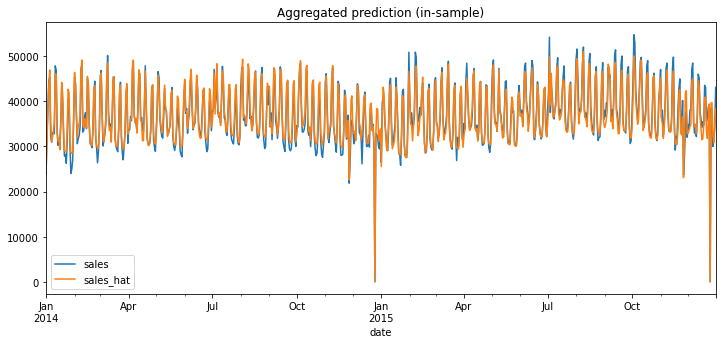

In [38]:
xy1_agg = xy1_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (in-sample)")
xy1_agg.to_dataframe().plot.line(ax=ax)
fig;

### Validate

Validation set: all known dates in 2016

In [39]:
xy2 = ds.sel(date=slice("2016-01-01", None))

In [40]:
xy2_hat = mdl.transform(xy2)

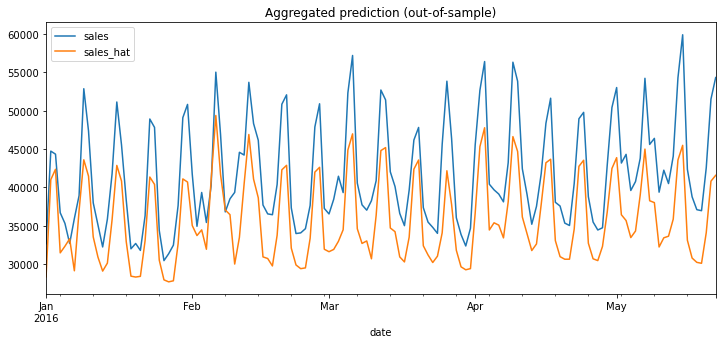

In [41]:
xy2_agg = xy2_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (out-of-sample)")
xy2_agg.to_dataframe().plot.line(ax=ax)
fig;

### Calculate error

The denominator is the MSE for the naive (1-step-ahead) forecast:

$$
mse_{naive} = \frac{1}{n-1} \sum_{t=2}^{n}{(Y_t-Y_{t-1})^2}
$$

We calculate error only after the first non-zero demand was observed.

The numerator is the MSE of your prediction, on the validation set:

$$
mse_{pred} = \frac{1}{h} \sum_{t=n+1}^{n+h} {(Y_t - \hat{Y_t})^2}
$$


The weights are just the value of sales during the last 28 days:

$$
w_i = \sum_{t=n-27}^{n}{Y_t \cdot price_t}
$$

Putting it all together, we get the Root Mean Squared Scaled Error (RMSSE):

$$
RMSSE = \sqrt{\frac{mse_{pred}}{mse_{naive}}}
$$

The weights are used to calculate the final metric (over all series):

$$
WRMSSE = \sum_{i=1}^{42840} {w_i * RMSSE_i}
$$

In [42]:
get_wrmsse(xy1, xy2_hat, t_hat="sales_hat")

0.9661849313228221

Note that an error greater than 1 means the forecast is worse than a 1-step-ahead naive/random walk forecast.
However, a 1-step-ahead forecast is impossible to use, because the forecast period is more than 1 day ahead.

In [43]:
errors_per_level = wrmsse_per_level(xy1, xy2_hat, t_hat="sales_hat")
errors_per_level

total            1.035950
state            1.067364
store            0.966185
cat              0.962510
dept             1.016614
state-cat        0.950558
state-dept       1.015632
store-cat        0.962510
store-dept       1.016614
product          0.966185
product-state    1.067364
product-store    0.966185
dtype: float64

This is the final error that would be shown on the leaderboard:

In [44]:
# result = wrmsse_total(xy1, xy2_hat, t_hat="sales_hat")
result = errors_per_level.mean()
result

0.9994726209588961

## Investigate model

### Importance

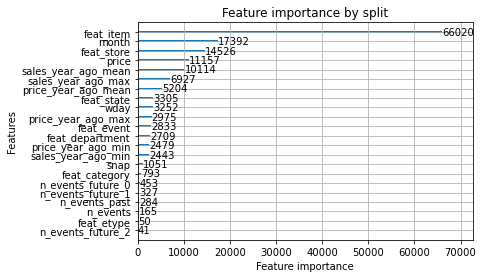

In [45]:
lgb.plot_importance(mdl.sk_obj, importance_type="split", title="Feature importance by split");

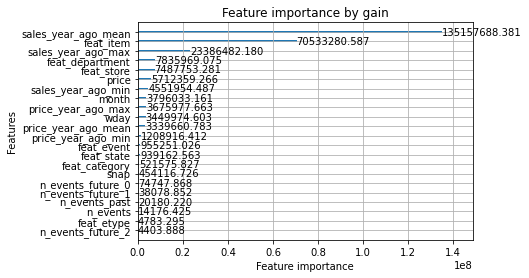

In [46]:
lgb.plot_importance(mdl.sk_obj, importance_type="gain", title="Feature importance by gain");

### SHAP

Prepare data for SHAP. **TODO**: Allow low-level control over dataframe in wrapper!

In [47]:
from nd_learn.compat.sklearn.wrap import _selection_helper_df
ds = xy2
self = mdl
predictor_vars = self.predictors.select(ds)
dims_obs = self.dims_obs
obs_coords = ds[dims_obs].stack({"obs": dims_obs})["obs"]

X: pd.DataFrame = _selection_helper_df(
    ds=ds,
    dims_obs=dims_obs,
    selected_vars=predictor_vars,
    obs_coords=obs_coords,
)
Xs = X.sample(1000, random_state=42)

Import and init shap.

In [48]:
import shap

In [49]:
shap.initjs()

In [50]:
explainer = shap.TreeExplainer(mdl.sk_obj, feature_names=Xs.columns)

In [51]:
shap_values = explainer.shap_values(Xs)

In [52]:
sv = explainer(Xs)

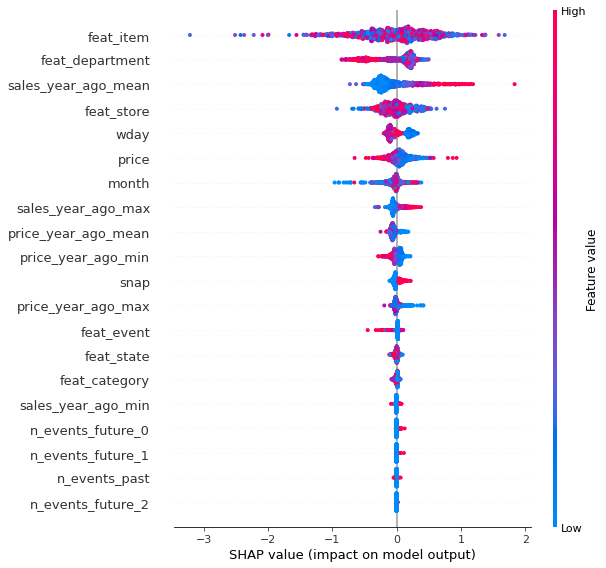

In [53]:
shap.summary_plot(shap_values, Xs)

In [54]:
# shap.force_plot(explainer.expected_value, shap_values[0:], Xs)

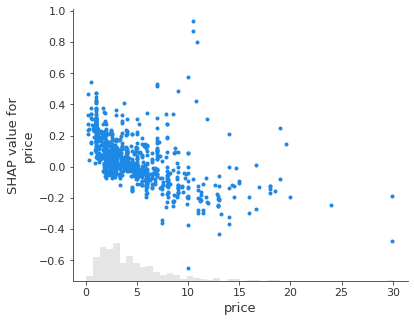

In [55]:
shap.plots.scatter(sv[:, "price"])

In [56]:
shap.force_plot(explainer.expected_value, shap_values[0], Xs.iloc[0])

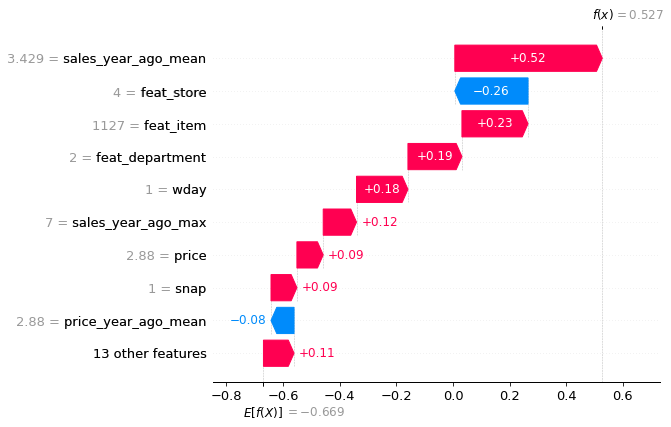

In [57]:
shap.waterfall_plot(sv[0])

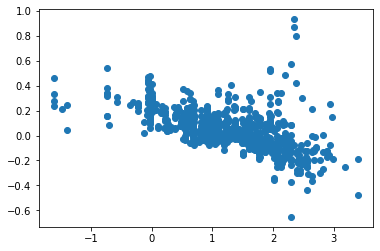

In [58]:
price_shap = sv[:, "price"].values
price_vals = sv[:, "price"].data
plt.scatter(np.log(price_vals), price_shap);

### Simulation

In [59]:
pcts = np.arange(0.9, 1.1, step=0.0025)
preds = pd.DataFrame(index=Xs.index)
for mult in pcts:
    Xd = Xs.copy()
    Xd['price'] = Xs['price'] * mult
    preds[mult] = mdl.sk_obj.predict(Xd)

In [60]:
base_pred = pd.Series(mdl.sk_obj.predict(Xs), index=Xs.index)

In [61]:
dlogy = preds.sub(base_pred, axis='rows').div(base_pred, axis='rows')
dlogx = pd.Series(pcts-1, index=pcts)
elasts_raw = dlogy.div(dlogx, axis='columns')
del elasts_raw[pcts[(len(pcts)-1)//2]]

In [62]:
elast_avg_per_change = elasts_raw.mean()

elast_std_per_change = elasts_raw.std()
elast_avg_global = elast_avg_per_change.mean()

In [63]:
from scipy import stats
_x = stats.norm.ppf(0.75)

In [64]:
stats.norm.cdf(0.6744) - stats.norm.cdf(-0.6744)

0.49994295725411875

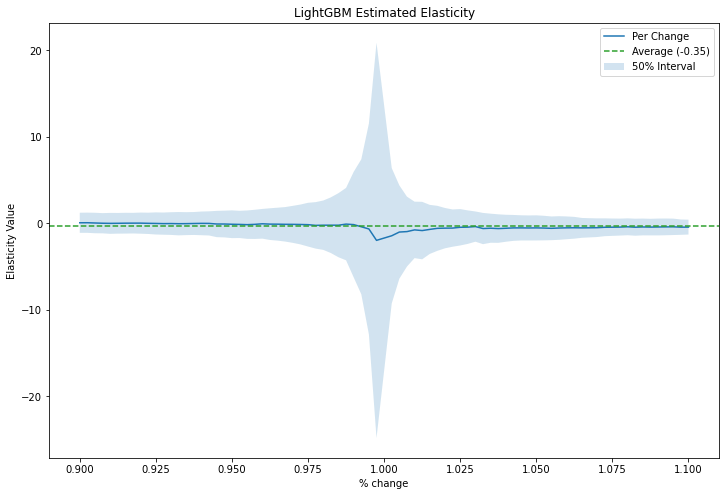

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
elasts_raw.mean().plot.line(ax=ax, label="Per Change")

ax.axhline(elast_avg_global, label=f"Average ({elast_avg_global:.2f})", color="C2", linestyle="--")
ax.fill_between(
    elast_avg_per_change.index,
    elast_avg_per_change - _x * elast_std_per_change,
    elast_avg_per_change + _x * elast_std_per_change,
    alpha=0.2,
    label="50% Interval",
)
ax.set_title("LightGBM Estimated Elasticity")
ax.set_xlabel("% change")
ax.set_ylabel("Elasticity Value")
ax.legend()
fig;